In [50]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

In [51]:
#Read in quarterly data from all mutual funds over all years in CRSP
fund_data = pd.read_csv('Mutual Fund Data.csv')
#Get only the Small Cap Value Funds
fund_data = fund_data[fund_data['lipper_class'] == 'SCVE']

c:\Users\amcre\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (3,10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [52]:
#Check for missing values in nav_latest
fund_data['nav_latest'].isnull().sum()

0

In [53]:
#find values of nav_latest that aren't float
fund_data['nav_latest'] = fund_data['nav_latest'].apply(lambda x: np.nan if type(x) != float else x)

In [54]:
#Compute returns by comparing NAV to NAV from the previous quarter
fund_data['return'] = fund_data.groupby(['fund_name'])['nav_latest'].pct_change()
#change the retail_fund column to a boolean
fund_data['retail_fund'] = fund_data['retail_fund'].apply(lambda x: 1 if x == 'Y' else 0).astype('category')
fund_data['retail_fund']

719        1
720        1
721        1
902        0
903        0
          ..
2433557    0
2433558    0
2433559    0
2433560    1
2433660    0
Name: retail_fund, Length: 29054, dtype: category
Categories (2, int64): [0, 1]

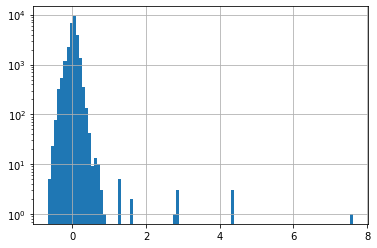

In [55]:
#plot histogram of returns with a log scale 
fund_data['return'].hist(bins=100, log=True)
#log transform the return column
fund_data['return'] = np.log(fund_data['return'] + 1)

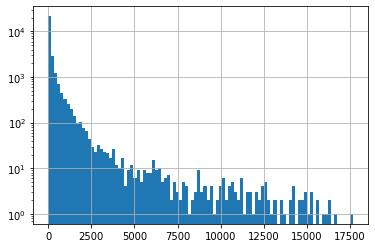

In [56]:
#drop rows where tna_latest is 0
fund_data = fund_data[fund_data['tna_latest'] != 0]
#plot histogram of tna_latest
fund_data['tna_latest'].hist(bins=100,log=True)
#log transform the tna_latest column
fund_data['tna_latest'] = np.log(fund_data['tna_latest'])

In [57]:
#get 5 bins of tna_latest
fund_data['tna_latest_bin'] = pd.qcut(fund_data['tna_latest'], 5, labels=False)
#drop rows with missing values in either return or tna_latest
fund_data = fund_data.dropna(subset=['return', 'tna_latest','mgmt_fee'])

In [58]:
#get dummies for tna_latest_bin
fund_data = pd.get_dummies(fund_data, columns=['tna_latest_bin'])

In [59]:
#find funds that have less than 20 observations and drop them
fund_data = fund_data.groupby('fund_name').filter(lambda x: len(x) > 20)
#create a dummy column for each fund name of type category
fund_data = pd.get_dummies(fund_data, columns=['fund_name'], drop_first=True)



In [60]:
#fit a regression model with return as the dependent variable and tna_latest, mgmt_fee, retail_fund, and the dummy columns as the independent variables
X = fund_data[['tna_latest_bin', 'mgmt_fee']]
y = fund_data['return']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

KeyError: "['tna_latest_bin'] not in index"

In [22]:
#get the correlation between tna_latest and return
fund_data['tna_latest'].corr(fund_data['return'])

0.03741093649756401

In [23]:
data = pd.read_csv('Mutual Fund Data 2.csv')

c:\Users\amcre\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (3,12,15,32,37,39,40,46,47,49,50,62) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [24]:
data = data[data['lipper_class'] == 'SCVE']

In [25]:
#find values of nav_latest that are string and convert to float
data['nav_latest'] = data['nav_latest'].apply(lambda x: float(x) if type(x) == str else x)
#find values of nav_latest that aren't float
data['nav_latest'] = data['nav_latest'].apply(lambda x: np.nan if type(x) != float else x)
data['return'] = (data['nav_latest']/data['nav_latest'].shift(1)) - 1

In [26]:
data_quant = data.select_dtypes(include=['float64'])

In [27]:
#find how many nan values are in each column
data_quant.isna().sum()
#drop yield, div_ytd, cap_gains_ytd, unrealized_app_dep, maturity, wbrger_obj_cd, policy 
data_quant = data_quant.drop(columns=['yield', 'div_ytd', 'cap_gains_ytd', 'unrealized_app_dep', 'maturity', 'wbrger_obj_cd', 'policy','merge_fundno'])

In [28]:
data_quant = data_quant.dropna()
#log transform the return column
data_quant['return'] = np.log(data_quant['return'] + 1)
#drop nav_latest and nav_52w_h
data_quant = data_quant.drop(columns=['nav_latest', 'nav_52w_h'])


In [29]:
#fit a regression predicting return with all the other columns from data_quant
X = data_quant.drop('return', axis=1)
y = data_quant['return']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 return   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     5.413
Date:                Sun, 09 Oct 2022   Prob (F-statistic):           6.29e-17
Time:                        19:22:18   Log-Likelihood:                 2705.9
No. Observations:                7138   AIC:                            -5360.
Df Residuals:                    7112   BIC:                            -5181.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              3.1375      1.889      1.661      0.097      -0.566       6.841
tna_latest      2.165e-06   3.49e-06      0.621      0.535   -4.67e-06       9e-06
per_com           -0.0345      0.006     -5.617      0.000      -0.046      -0.022
per_pref          -0.0301      0.008     -3.896      0.000      -0.045      -0.015
per_conv          -0.0327      0.007     -4.801      0.000      -0.046      -0.019
per_corp          -0.0344      0.007     -4.799      0.000      -0.048      -0.020
per_muni          -0.0329      0.008     -3.896      0.000      -0.049      -0.016
per_govt          -0.0344      0.006     -5.565      0.000      -0.047      -0.022
per_oth           -0.0344      0.006     -5.611      0.000      -0.046      -0.022
per_cash          -0.0345      0.006     -5.631      0.000      -0.047      -0.023
per_bond          -0.0338      0.006     -5.234      0.000      -0.046      -0.021
per_abs           -0.1732      0.584     -0.296      0.767      -1.319       0.972
per_mbs            0.0169      0.204      0.083      0.934      -0.384       0.417
per_eq_oth        -0.0328      0.006     -5.053      0.000      -0.046      -0.020
per_fi_oth        -0.0357      0.008     -4.696      0.000      -0.051      -0.021
crsp_portno     2.029e-06   2.76e-07      7.345      0.000    1.49e-06    2.57e-06
crsp_cl_grp     2.121e-07   1.47e-07      1.447      0.148   -7.51e-08    4.99e-07
mgr_dt         -3.724e-08   5.37e-08     -0.693      0.488   -1.43e-07    6.81e-08
first_offer_dt -7.557e-08   4.49e-08     -1.683      0.092   -1.64e-07    1.25e-08
end_dt           2.21e-07   6.88e-08      3.214      0.001    8.62e-08    3.56e-07
actual_12b1       -0.0850      2.079     -0.041      0.967      -4.161       3.991
max_12b1           0.1918      1.938      0.099      0.921      -3.607       3.991
mgmt_fee          -0.0002      0.000     -0.568      0.570      -0.001       0.000
exp_ratio         -0.3596      0.732     -0.491      0.623      -1.794       1.075
turn_ratio         0.0013      0.001      1.215      0.224      -0.001       0.004
fiscal_yearend -2.179e-07    6.8e-08     -3.205      0.001   -3.51e-07   -8.46e-08
==============================================================================
Omnibus:                     2366.324   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           220331.691
Skew:                          -0.627   Prob(JB):                         0.00
Kurtosis:                      30.189   Cond. No.                     5.67e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.67e+10. This might indicate that there are
strong multicollineari

In [30]:
#get the coefficient for tna_latest
model.params['tna_latest']

2.164649548082119e-06

<AxesSubplot:xlabel='per_abs', ylabel='return'>

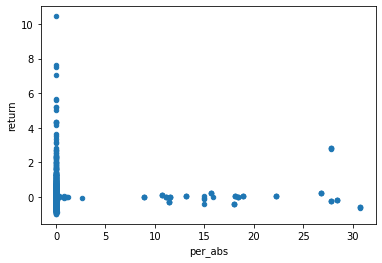

In [31]:
#plot return against div_ytd
data.plot.scatter(x='per_abs', y='return')

In [32]:
#find number of missing values for div_ytd
data['div_ytd'].isna().sum()

22422